installing and importing packages - this way it should work both with colab and jupyter notebook in anaconda

In [ ]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy 
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install osmnx 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import osmnx as ox
import urllib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Getting the traffic accident data

*It's not that I am trying to sneak car accidents in the weater, it's just some data I had on hand:)*

In [ ]:
#not sure if links are permanent, see https://daten.berlin.de/search/node/Stra%C3%9Fenverkehrsunf%C3%A4lle%20nach%20Unfallort
accidents_21 = pd.read_csv('https://download.statistik-berlin-brandenburg.de/c2b6d25afa19b607/8d9164595b8b/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_2021_Datensatz.csv',\
                          header=0, sep=';')

print(accidents_21.head())
print(accidents_21.dtypes)
accidents_21.shape

   OBJECTID  LAND  BEZ  LOR_ab_2021  UJAHR  UMONAT  USTUNDE  UWOCHENTAG   
0    219249    11    3    3701658.0   2021      11       18           2  \
1    219248    11    7    7501134.0   2021      12       19           7   
2    219247    11    4    4100101.0   2021      12       17           4   
3    219246    11    4    4501041.0   2021      12       15           7   
4    219243    11   11   11501339.0   2021      12        9           5   

   UKATEGORIE  UART  ...  IstPKW  IstFuss  IstKrad  IstGkfz  IstSonstige   
0           3     0  ...       1        0        1        0            0  \
1           3     6  ...       1        1        0        0            0   
2           3     5  ...       1        0        0        0            0   
3           3     5  ...       1        0        1        0            0   
4           3     3  ...       1        0        0        0            1   

   USTRZUSTAND      LINREFX      LINREFY    XGCSWGS84    YGCSWGS84  
0            1  800202,

(11267, 23)

<Axes: title={'center': 'Accidents per month'}, xlabel='Month', ylabel='Accidents'>

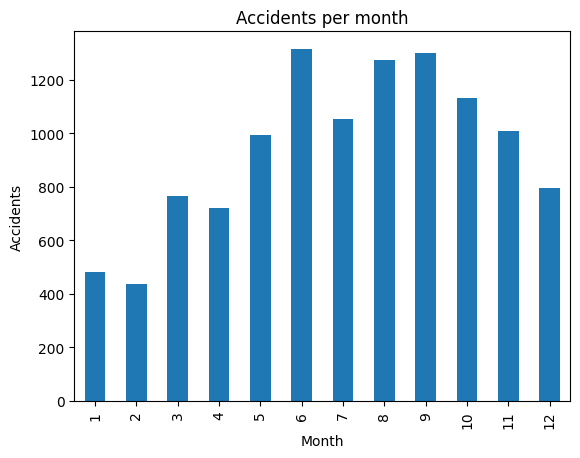

In [ ]:
accidents_21.value_counts('UMONAT',sort=False).plot(kind='bar',title='Accidents per month', xlabel='Month',ylabel='Accidents')

Now I do something with geopandas, more for a sake of changing the notebook:)

In [ ]:
accidents_21.YGCSWGS84 = accidents_21.YGCSWGS84.str.replace(',','.').astype(float)
accidents_21.XGCSWGS84 = accidents_21.XGCSWGS84.str.replace(',','.').astype(float)
gdf_accidents_21 = gpd.GeoDataFrame(accidents_21, geometry = gpd.points_from_xy(accidents_21.XGCSWGS84, accidents_21.YGCSWGS84))
print(gdf_accidents_21.head())

   OBJECTID  LAND  BEZ  LOR_ab_2021  UJAHR  UMONAT  USTUNDE  UWOCHENTAG   
0    219249    11    3    3701658.0   2021      11       18           2  \
1    219248    11    7    7501134.0   2021      12       19           7   
2    219247    11    4    4100101.0   2021      12       17           4   
3    219246    11    4    4501041.0   2021      12       15           7   
4    219243    11   11   11501339.0   2021      12        9           5   

   UKATEGORIE  UART  ...  IstFuss  IstKrad  IstGkfz  IstSonstige  USTRZUSTAND   
0           3     0  ...        0        1        0            0            1  \
1           3     6  ...        1        0        0            0            1   
2           3     5  ...        0        0        0            0            0   
3           3     5  ...        0        1        0            0            1   
4           3     3  ...        0        0        0            1            2   

       LINREFX      LINREFY  XGCSWGS84  YGCSWGS84             

                                            geometry  bbox_north  bbox_south   
0  MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...   52.675509   52.338245  \

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon   
0  13.761161  13.088345  297954385  relation   62422  52.517037  13.38886  \

      display_name     class            type  importance  
0  Berlin, Germany  boundary  administrative    1.007539  


<Axes: >

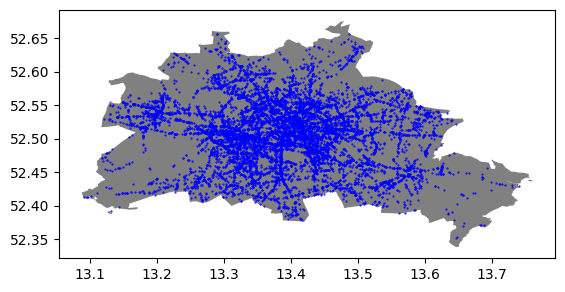

In [ ]:
city = ox.geocode_to_gdf('Berlin, Germany')
print(city.head())
ax = ox.project_gdf(city).to_crs("EPSG:4326").plot(fc='gray')
gdf_accidents_21.plot(ax=ax,markersize = 1, color = 'blue',marker = '.')

Import geometry of voting districts

In [ ]:
url='https://download.statistik-berlin-brandenburg.de/db8c83613aceb93e/14a42eb32a76/RBS_OD_UWB_AH21.zip'
filename = 'RBS_OD_UWB_AH21.zip'
urllib.request.urlretrieve(url, filename)
file = "RBS_OD_UWB_AH21.zip!RBS_OD_UWB_AH21.shp"
vote_geom = gpd.read_file(file).to_crs("EPSG:4326")
print(vote_geom.head())
print(vote_geom.dtypes)
print(vote_geom.info)

     UWB UWB3   BWB BWB3   AWK BEZ BWK   
0  01100  100  011A   1A  0101  01  75  \
1  01101  101  011B   1B  0101  01  75   
2  01102  102  011B   1B  0101  01  75   
3  01103  103  011C   1C  0101  01  75   
4  01104  104  011D   1D  0101  01  75   

                                            geometry  
0  POLYGON ((13.37094 52.52692, 13.36956 52.52890...  
1  POLYGON ((13.36896 52.53377, 13.36673 52.53577...  
2  POLYGON ((13.36896 52.53377, 13.36904 52.53381...  
3  POLYGON ((13.38218 52.53126, 13.38217 52.53127...  
4  POLYGON ((13.38798 52.52936, 13.38535 52.52871...  
UWB           object
UWB3          object
BWB           object
BWB3          object
AWK           object
BEZ           object
BWK           object
geometry    geometry
dtype: object
<bound method DataFrame.info of         UWB UWB3   BWB BWB3   AWK BEZ BWK   
0     01100  100  011A   1A  0101  01  75  \
1     01101  101  011B   1B  0101  01  75   
2     01102  102  011B   1B  0101  01  75   
3     01103  103  011C 

In [ ]:
np.size(vote_geom.UWB.unique())

2257

In [ ]:
gdf_accidents_21.geometry.within(vote_geom.geometry[1]).value_counts()

False    11259
True         8
Name: count, dtype: int64